In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Praca domowa 5 - klasteryzacja

Zadaniem jest klasteryzacja podanych punktów w przestrzeni $R^2$.

Przyrzyjmy się najpierw jak wyglądają dane.

In [4]:
data = pd.read_csv('clustering.csv',header=None)

In [5]:
data.head(5)

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


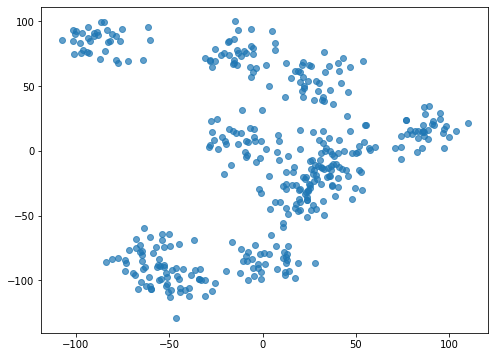

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(x=data[0], y = data[1], alpha = 0.7)
plt.show()

In [87]:
from sklearn.metrics import silhouette_score
def plot_result(X, model, fitted=False, **params):
    y_pred = model.fit_predict(X)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred, cmap='brg', **params)
    plt.show()
    print("Silhouette mean coefficient: ", silhouette_score(X, model.labels_))

## Algorytm k-means

Jest to najpopularniejszy algorymt klasteryzacji. Dla ustalonej liczby skupień algorytm przydziela każdą obserwację do najbliższego skupienia (najbliżej środka skupienia, który jest wyliczany jako średnia spośród obserwacji należących do skupienia). Cały proces jest iterowany do momentu gdy zmiany pozycji środków skupień są mniejsze od ustalonej wartości.

Podstawowa wersja algorytmu losowo inicjalizuje pozycje początkowe środków skupień. Może to czasem powodować niestabilność, np. gdy dwa środki zainicjalizują się blisko siebie w obrębie tego samego właściwego skupienia. Dlatego implementacja k-means w bibliotece scikit-learn domyślnie korzysta z algorytmu inicjalizacji, który inicjalizuje środki skupień daleko od siebie (*k-means++: https://en.wikipedia.org/wiki/K-means%2B%2B*).

Dobierzmy teraz za pomocą metody łokcia odpowiednią liczbę skupień.

In [88]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

scores = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    inertia = kmeans.inertia_
    scores.append(inertia)

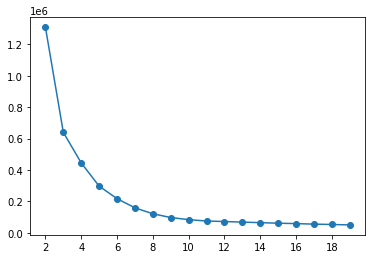

In [89]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots()
ax.plot(list(range(2,20)), scores, marker ='o')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

Moment ugięcia następuje przy liczbie skupień równej k=8. Dalsze zwiększanie tej liczby nie poprawia znacząco miary bezwładności (średni kwadrat odległości punktu od środka skupienia do którego został przydzielony).

Inną miarą możę być współczynnik silhouette'a, przyjmujący wartości od -1 do 1 dla każdego punktu, gdzie -1 oznacza źle przydzielone skupisko, 0 oznacza że punkt jest blisko granicy skupiska, 1 oznacza że punkt znajduje się blisko środka skupienia, daleko od innych skupisk.

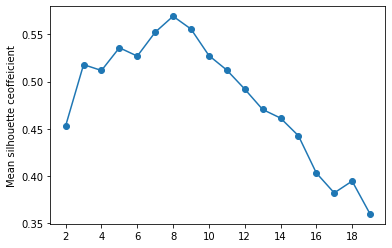

In [90]:
from sklearn.metrics import silhouette_score
scores = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    sh_score = silhouette_score(data, kmeans.labels_)
    scores.append(sh_score)
fig, ax = plt.subplots()
ax.plot(list(range(2,20)), scores, marker ='o')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Mean silhouette ceoffeicient")
plt.show()

Powyższy wykres wskazuje że również w przypadku metryki średniej wartości współczynnika silhouette'a parametr k=8 najlepszy. Można też zauważyć że wartości k=7, k=9 również dają porównywalne wyniki. Możemy się im dokładniej przyjżeć za pomocą poniższych wykresów.

In [91]:
# source: https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import matplotlib as mpl

def silhouette_coefficients(model_class, n_clusters, X, fig_size=(9,6)):
    f = plt.figure(figsize=fig_size)
    y_pred = model_class(n_clusters=n_clusters).fit_predict(X)
    silhouette_s = silhouette_score(X, y_pred)
    silhouette_coefficients = silhouette_samples(X, y_pred)
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(n_clusters):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.inferno(i / n_clusters)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding
    plt.axvline(x=silhouette_s, linestyle='--', color='r')
    plt.title(f'k={n_clusters}', fontsize=14)

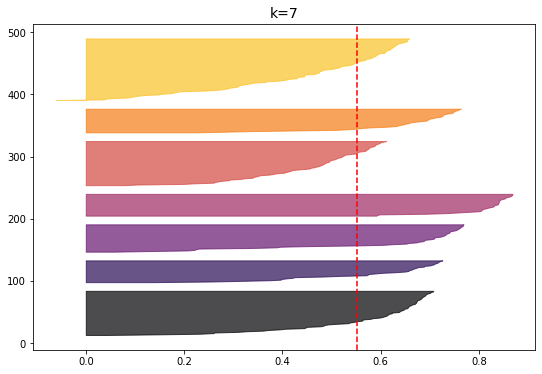

In [92]:
silhouette_coefficients(KMeans, 7, data)

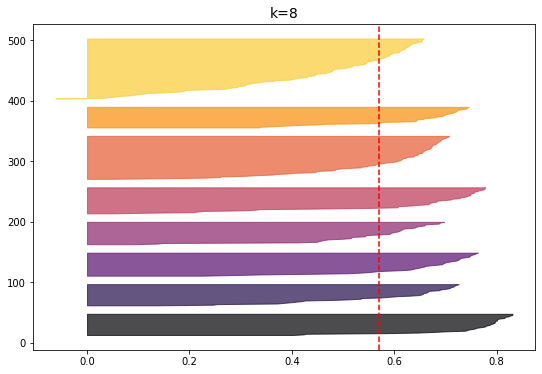

In [93]:
silhouette_coefficients(KMeans, 8, data)

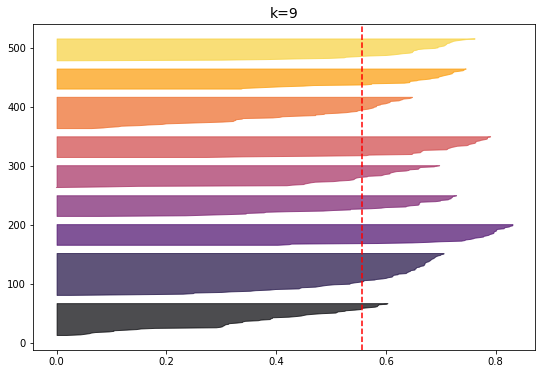

In [94]:
silhouette_coefficients(KMeans, 9, data)

Dla k=7 widać że dwa z klastrów posiadają znaczną większość obserwacji z współczynnikiem niższym od średniej i może to oznaczać że obserwacje znajdują się zbyt blisko innej grupy, co może być argumentem za odrzuceniem tej wartości k. Dla k=8 i k=9 jeden z klastrów posiada wiele elementów poniżej średniej. Jednak k=9 wydaje się lepszym wyborem, ponieważ w k=8 są elementy posiadające ujemny współczynnik silhouette'a oraz klastry w k=9 są bardziej równoliczne.

Poniżej przedstawione są wykresy jak wyglądają sklasteryzowane punkty dla k=8 i k=9.

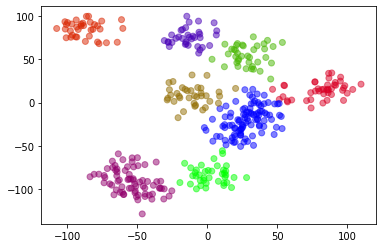

Silhouette mean coefficient:  0.5692668571425796


In [99]:
plot_result(data, KMeans(n_clusters=8), alpha=0.5)

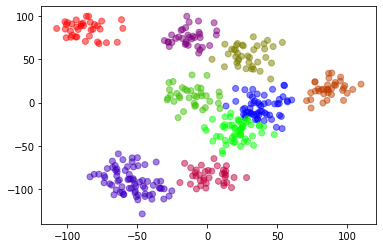

Silhouette mean coefficient:  0.555566014452709


In [100]:
plot_result(data, KMeans(n_clusters=9), alpha=0.5)

## Klasteryzacja hierarchiczna (aglomeracyjna)

Innym podejściem do klasteryzacji punktów jest klasteryzacja hierarchiczna, a konkretnie aglomeracyjna. Polega ona (zaczynając od klastrów zawierających po jednym punkcie) na scalaniu kolejnych najbliższych sobie klastrów. Kryterium połączenia się klastrów może być definiowane na wiele sposobów co pozwala dostosować algorytm do naszych potrzeb.

Przetestujmy dostępne kryteria i porównajmy wyniki (w metryce średniej wartości wspołczynnika silhouette'a) ze sobą oraz z wynikiem algorytmu k-means dla k=8 (oznaczone czerwoną linią).

In [101]:
from sklearn.cluster import AgglomerativeClustering
rows = []
for linkage in ['ward', 'complete', 'average', 'single']:
    for k in range(3, 11):
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        model.fit(data)
        sh_score = silhouette_score(data, model.labels_)
        rows.append({'linkage':linkage, 'k':k, 'sh_score':sh_score})
scores_df = pd.DataFrame(rows)

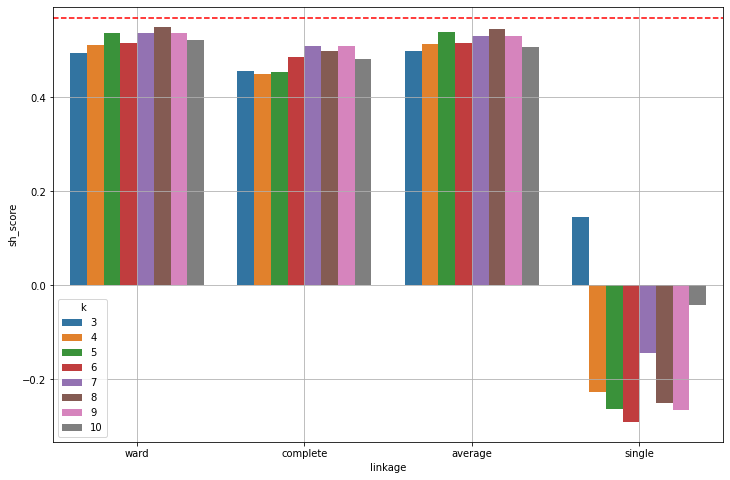

In [102]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='linkage', y='sh_score', hue='k', data=scores_df)
plt.axhline(y=0.569, linestyle='--', color='r')
plt.grid(True)

Tutaj również k=8 dawało najlepsze wyniki średniej wartości wsp. silhouette'a, które były nieco gorsze od tych z wykorzystaniem k-means. Wszystkie kryteria łączeń klastrów wypadły podobnie oprócz kryterium `single` (czyli łączenie następuje dla klastrów, które mają sąsiadujące punkty najbliżej siebie), które osiągnęło bardzo złe wyniki.
Najwyższy wynik uzyskano dla kryterium `ward` (łączy te klastry, których połączenie da najmniejszą wariancję) z k=8. 

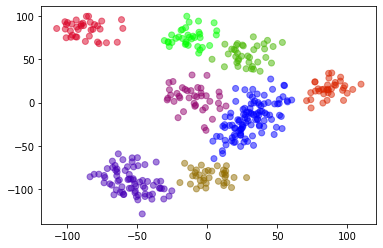

Silhouette mean coefficient:  0.5506938439944645


In [104]:
plot_result(data, AgglomerativeClustering(linkage='ward', n_clusters=8), alpha=0.5)

Różnica w wynikach oby algorytmów na naszym przykładzie była niewielka, jednak algorytmy hierarchiczne mają znaczą przewagę w przypadkach gdy klastry są bardziej eliptycznie lub mają bardziej skomplikowane kształty.

![](clustering.png)

*źródło: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering*